# CLIP + SAM

In [1]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

In [2]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="c:\\Users\\Riley\\Desktop\\sam_vit_h_4b8939.pth"))

C:\Users\Riley\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any 

In [3]:
image_path = "c:\\Users\\Riley\\Desktop\\Portal\\Code\\Images\\0009_V0075836F.jpg"

In [5]:
image = Image.open(image_path)
image = image.resize((1500, 2300))
image = np.array(image)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

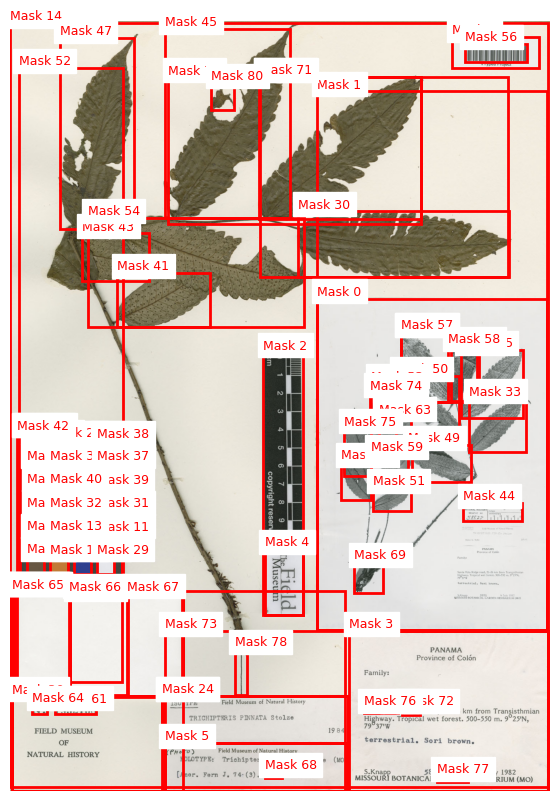

In [6]:

import matplotlib.pyplot as plt

# Display the image with bounding boxes and predictions
def show_bounding_boxes(image, masks):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Loop over each mask and draw bounding box
    for i, mask in enumerate(masks):
        # Get the bounding box coordinates
        bbox = mask['bbox']
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # Display the prediction or mask ID near the bounding box
        ax.text(x, y - 10, f"Mask {i}", color='red', fontsize=9, backgroundcolor="white")

    plt.axis('off')
    plt.show()

# Call the function with the current image and masks
show_bounding_boxes(image, masks)


In [7]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [8]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [9]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [10]:
#Make sure it works
import clip
print(dir(clip))

#check versions
import torch
print(torch.__version__)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'available_models', 'clip', 'load', 'model', 'simple_tokenizer', 'tokenize']
2.4.1+cu118


In [11]:
# Load CLIP
import clip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [12]:
@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [13]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

C:\Users\Riley\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


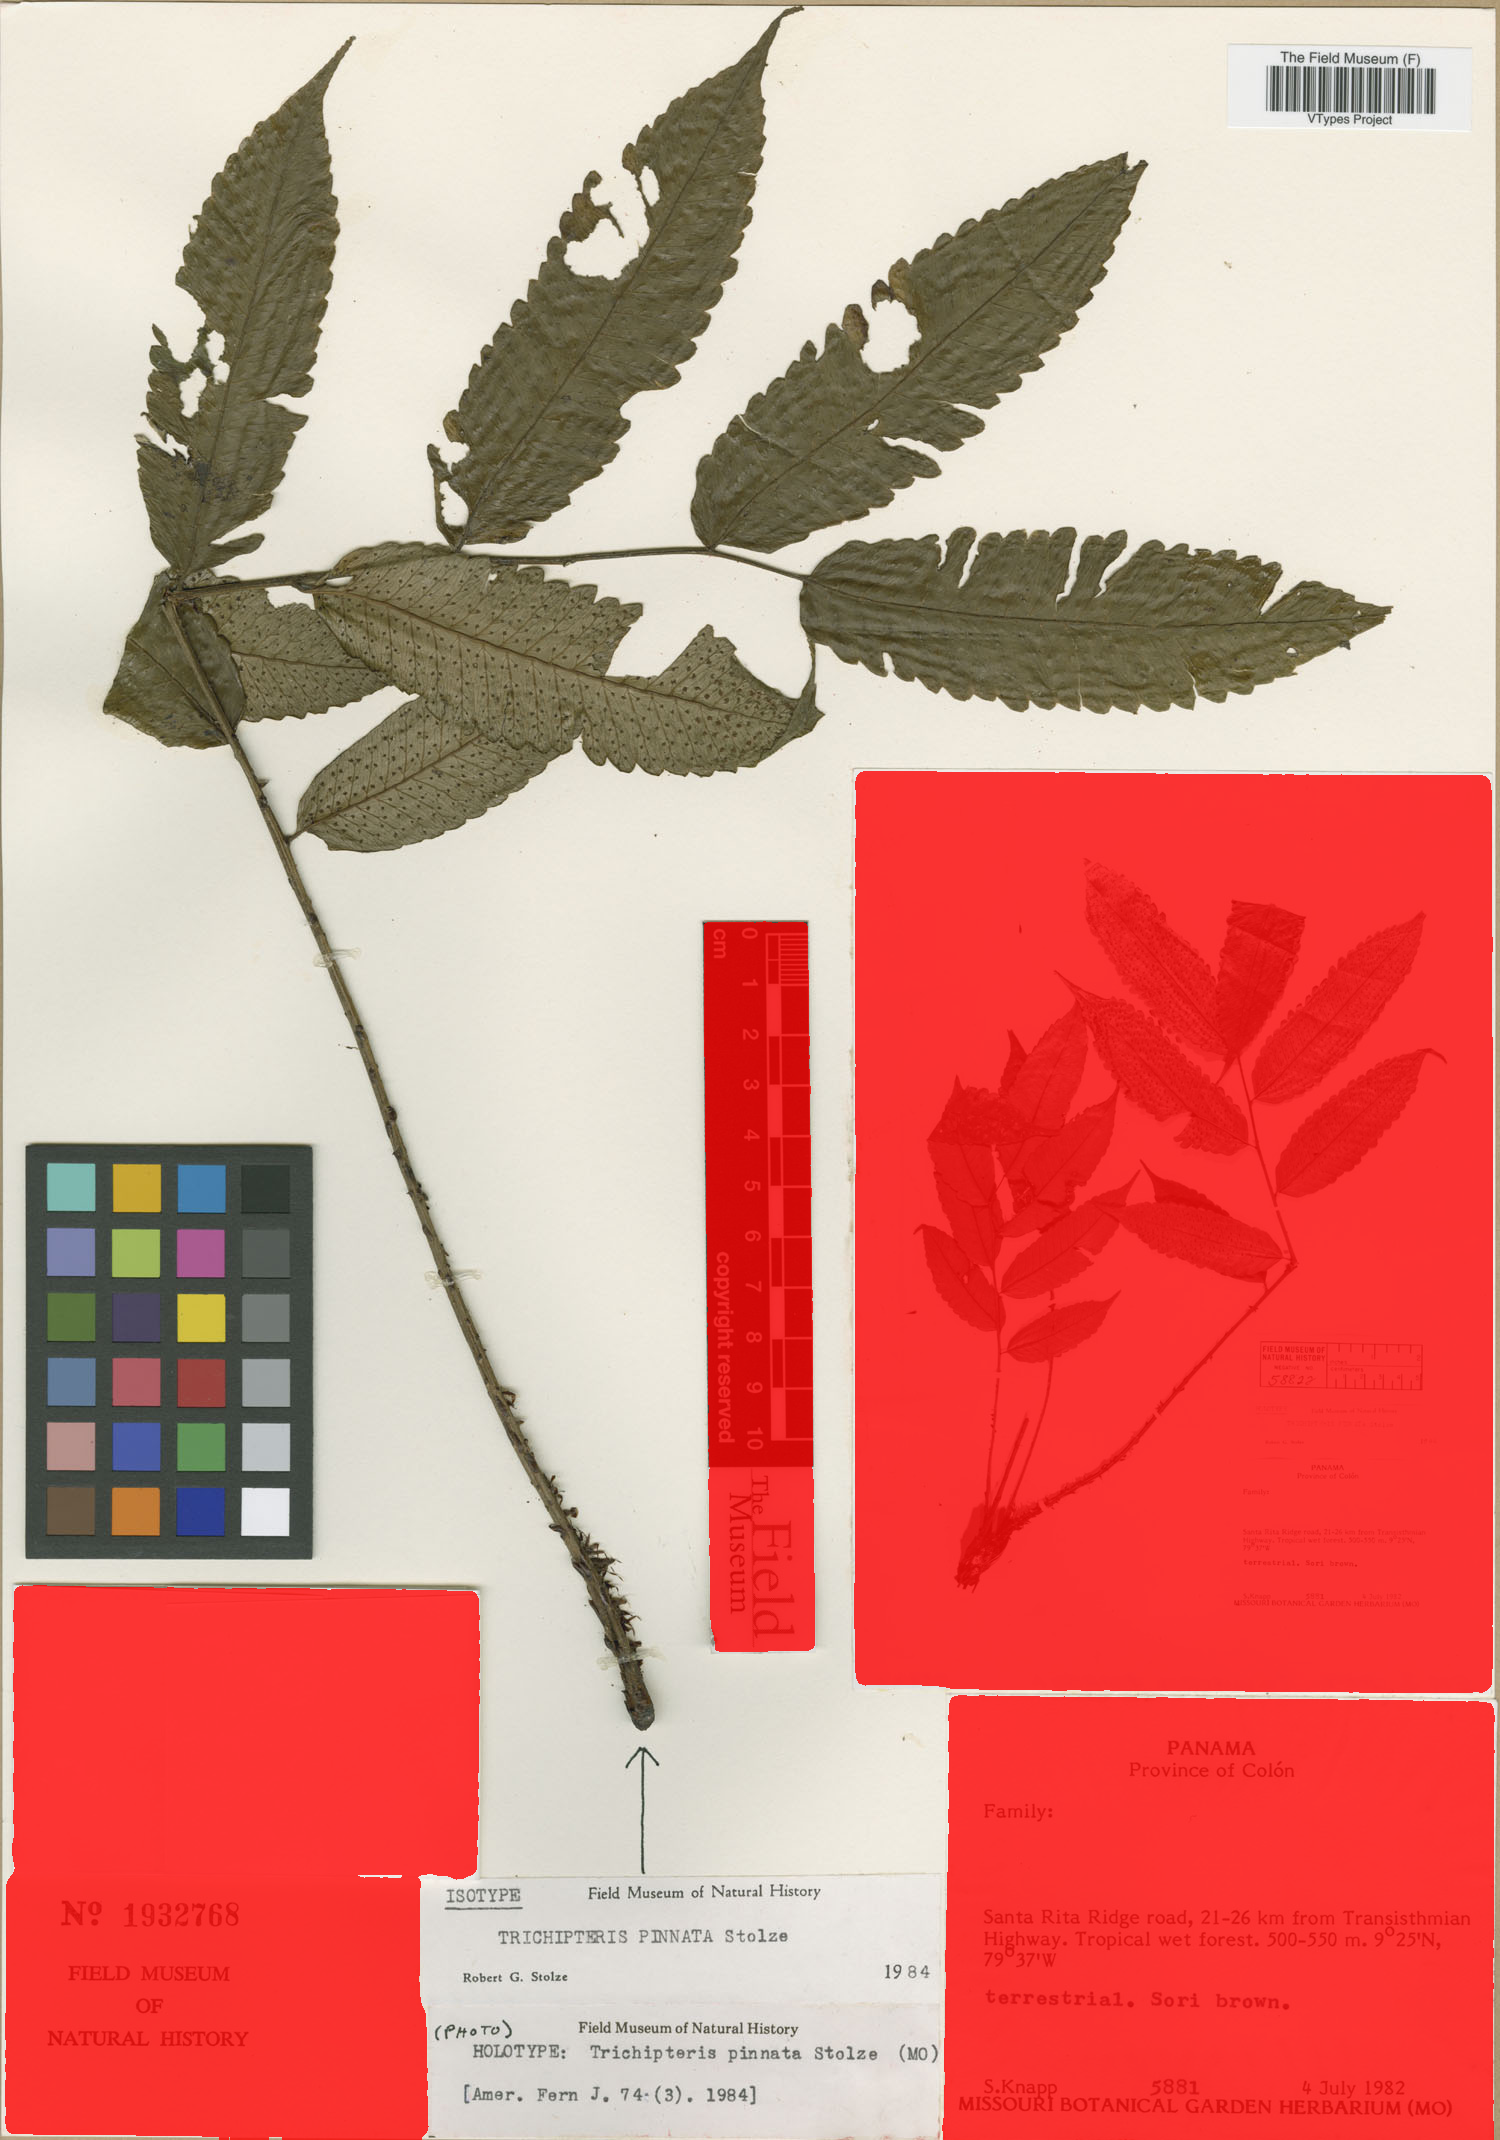

In [ ]:

prompts = [
    "words", 
    "text",  
    "numbers",  
    "labels",            
    "names of people",
    "label text",
    "botanical annotations", 
    "locality information",
    "printed and handwritten text"
    "Country, city, and date",
    "record Numbers",
    "small regions of text and labels",
    "Field Museum of Natural History",
    
              
]

# prompts = [
#     "label text, botanical annotations, locality information"
# ]

# Initialize an empty list for all segmentation masks
segmentation_masks = []

# Loop over each prompt and retrieve masks that meet the threshold
for prompt in prompts:
    scores = retriev(cropped_boxes, prompt)  # Retrieve scores for esach prompt
    #print(scores)
    indices = get_indices_of_values_above_threshold(scores, 0.35)

    # Collect masks for each prompt's detected regions
    for seg_idx in indices:
        segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
        segmentation_masks.append(segmentation_mask_image)

# Prepare overlay on the original image
original_image = Image.open(image_path)
overlay_image = Image.new('RGBA', original_image.size, (0, 0, 0, 0))
overlay_color = (255, 0, 0, 200)

# Draw each segmentation mask on the overlay image
draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

# Composite the overlay on the original image and display the result
result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)

result_image
